# Restaurant Review & Lingusitic Features Analytics

# Load Data

In [1]:
import os

import pandas as pd

# ====== Preprocessing ==========================
# Read raw data
master_dir = os.path.dirname(os.getcwd())

# Google
file_google = os.path.join(master_dir, "data_cleaned",
                           "GoogleReview_data_cleaned.csv")
# TripAdvisor
file_tripadvisor = os.path.join(master_dir, "data_cleaned", "TripAdvisor_data_cleaned.csv")

df_google = pd.read_csv(file_google)
df_TA = pd.read_csv(file_tripadvisor)

# Preprocessing

In [2]:
# combine reviews
df = pd.concat([df_TA, df_google], axis=0)
df_ori = df.copy()

In [3]:
# number of records
sampleNum = df.index.size
print(f"Sample Number: {sampleNum}")

Sample Number: 361784


In [4]:
# number of restaurants
uniqueRestaurants = df['Restaurant'].unique().size
print(f"Unique Restaurants: {uniqueRestaurants}")

Unique Restaurants: 3515


In [5]:
# Subset wanted coluns
df = df[['Review', 'Rating']]
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
# Adding labels
def labelFunc(x):
    if int(x) > 3:
        return "Positive"
    elif int(x) < 3:
        return "Neutral"
    elif int(x) == 3:
        return "Negative"

# Add sentiment label
df_ori["Label"] = df_ori["Rating"].apply(labelFunc)

# Exploratory Data Analysis (EDA)

## Distribution of data

### Distribution across different location

In [7]:
df_ori["Location"].value_counts()

KL               98750
Petaling Jaya    49932
Penang           44502
JB               35238
Ipoh             30796
Kuching          29603
Langkawi         29303
Melaka           26690
Shah Alam         8658
Miri              8312
Name: Location, dtype: int64

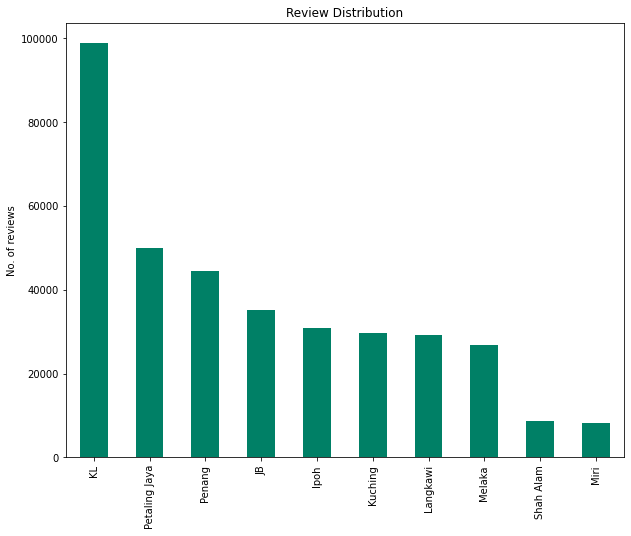

In [8]:
df_ori["Location"].value_counts().plot(kind='bar',
                                       figsize=(10, 8),
                                       ylabel="No. of reviews",
                                       title="Review Distribution",
                                       cmap='summer',
                                      );

Highest on review on Kuala Lumpur, lowest on Miri.

### Rating Distribution

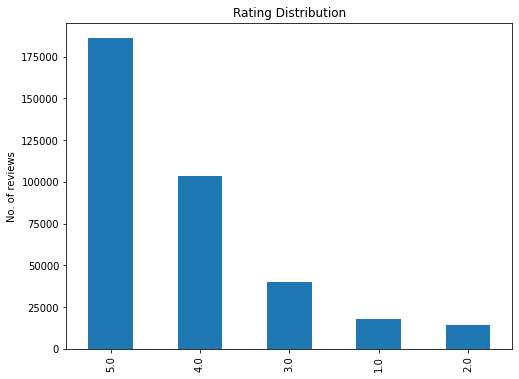

In [9]:
# Rating Distribution
df_ori["Rating"].value_counts().plot(kind='bar',
                                     figsize=(8, 6),
                                     ylabel="No. of reviews",
                                    title="Rating Distribution");

In [10]:
# Average Rating
avgRating = df_ori["Rating"].mean().round(2)
print(f"Average Rating: {avgRating}")

Average Rating: 4.18


Rating sckewed towards the high (Positive sentiment) side, as the average rating is 4.18.

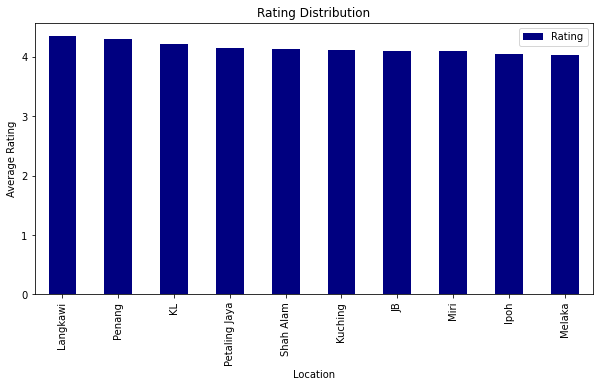

In [11]:
# Average rating across different locations

df_ori.pivot_table(index='Location', values='Rating', aggfunc='mean') \
    .sort_values('Rating', ascending=False) \
    .plot(kind='bar', ylabel="Average Rating",
          title="Rating Distribution", figsize=(10, 5), cmap='jet'
         );

Langkawi on average has the highest average review rating, whereas the lowest is Melaka.

### Sentiment Distribution

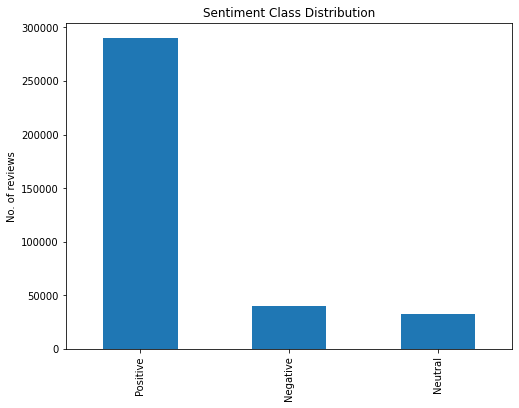

In [12]:
df_ori["Label"].value_counts().plot(kind='bar',
                                     figsize=(8, 6),
                                     ylabel="No. of reviews",
                                    title="Sentiment Class Distribution");

In [13]:
# Proportion of sentiment type
pd.DataFrame(df_ori["Label"].value_counts() / df_ori.index.size * 100) \
    .rename(columns={'Label': "Percentage"})

Percentage
Positive   80.087842
Negative   11.010714
Neutral     8.901444

More than 80% of the reviews are positive reviews, whereas the neutral and negative rewviews have around 10% each

### Top Restaurants

#### Overall Top restaurants based on average rating

In [14]:
averageRating_restaurants = df_ori[["Restaurant", "Rating"]] \
                .pivot_table(index=['Restaurant'], values='Rating', aggfunc='mean') \
                .sort_values('Rating', ascending=False)
averageRating_restaurants.head(10)

Rating
Restaurant                        
Spiced Pumpkin Cafe            5.0
Baan Carabao                   5.0
Latte Be Light                 5.0
Ayam Penyet                    5.0
Restaurant Pin Wei Seafood     5.0
Restaurant Smk Corner          5.0
Restaurant Soon Tong           5.0
Thirty8 Fashion                5.0
Canard eat & roll              5.0
Restoran Bendang               5.0

May not be reflective, as some restaurant with high rating may have very less review

#### Top restaurants : Combined scoring for reviews count and rating, using sum of rating

In [15]:
# get the frequency of each restaurant
restaurant_reviewcount = pd.DataFrame(df_ori["Restaurant"].value_counts())
restaurant_reviewcount = restaurant_reviewcount.reset_index().rename(columns={'index': "Restaurant", 'Restaurant': 'Review Count'})

In [16]:
# sort by review count first, then average rating
overall_toprestaurants = averageRating_restaurants \
    .reset_index().merge(restaurant_reviewcount, on='Restaurant') \
    .sort_values(by=['Review Count', 'Rating'], ascending=False).head(10)
overall_toprestaurants

Restaurant    Rating  Review Count
406           Dining In The Dark KL  4.672455          2073
819           Ishin Japanese Dining  4.459525          2063
876           Khan’s Indian Cuisine  4.429253          1887
2625                 Hard Rock Cafe  3.826692          1581
933           Wonderland Food Store  4.403743          1496
2739                Geographer Cafe  3.753274          1451
965                      BBQ NIGHTS  4.398628          1312
361                  The Whisky Bar  4.735202          1284
245   Canopy Rooftop Bar and Lounge  4.880126          1268
2600              Madam Kwan's KLCC  3.843849          1268

In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=overall_toprestaurants['Restaurant'], 
               y=overall_toprestaurants['Rating'], name="Rating", mode="lines"),
    secondary_y=True
)

fig.add_trace(
    go.Bar(x=overall_toprestaurants['Restaurant'],
           y=overall_toprestaurants['Review Count'], name="Review Count"),
    secondary_y=False
)

fig.update_xaxes(title_text="Review Count")

# Set y-axes titles
fig.update_yaxes(title_text="Review Count", secondary_y=False)
fig.update_yaxes(title_text="Rating", secondary_y=True)

fig.show()

### Relationship between review length and rating

In [20]:
import nltk

tokenizer = nltk.RegexpTokenizer(r"\w+")

df_ori['Word_count'] = df_ori['Review'].apply(lambda x: len(tokenizer.tokenize(x)))

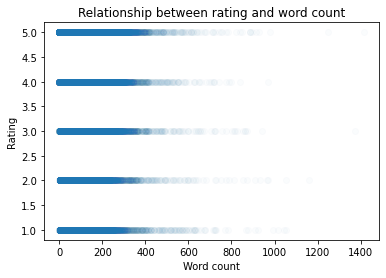

In [23]:
import matplotlib.pyplot as plt

plt.scatter(x=df_ori['Word_count'], y=df_ori['Rating'], alpha=0.02)
plt.xlabel('Word count')
plt.ylabel('Rating')
plt.title('Relationship between rating and word count');

In [24]:
df_ori[['Word_count', 'Rating']].corr()

Word_count    Rating
Word_count    1.000000 -0.111255
Rating       -0.111255  1.000000

No direct correlationship can be observed. Only slightly negatively correlated, in which longer review tends to be lower rating

## Timeseries Analysis

In [25]:
import datetime
import re
import matplotlib.pyplot as plt

def dateconvert(x, startdate):
    match = re.search(r"(\bweek(s)?\b)|(\bday(s)?\b)", x)
    if match:
        delta = int(re.search("\d+", x)[0])
        # weeks
        if re.search(r"\bweek(s)?\b", x):
            date = startdate - datetime.timedelta(weeks=delta)
        # days
        elif re.search(r"\bday(s)?\b", x):
            date = startdate - datetime.timedelta(days=delta)
    elif x in "yesterday":
        date = startdate - datetime.timedelta(days=1)
    elif x in "today":
        date = startdate
    else:
        date = datetime.datetime.strptime(x, "%d %B %Y")
    return date

In [26]:
# Review Timeline
df_TA["Date"] = df_TA["Dates"].str.replace(r"Reviewed\s", "", regex=True).str.strip()
df_TA["Date"] = df_TA["Date"].apply(dateconvert, startdate=datetime.date(2022, 4, 30));

### Overall no. of reviews per month

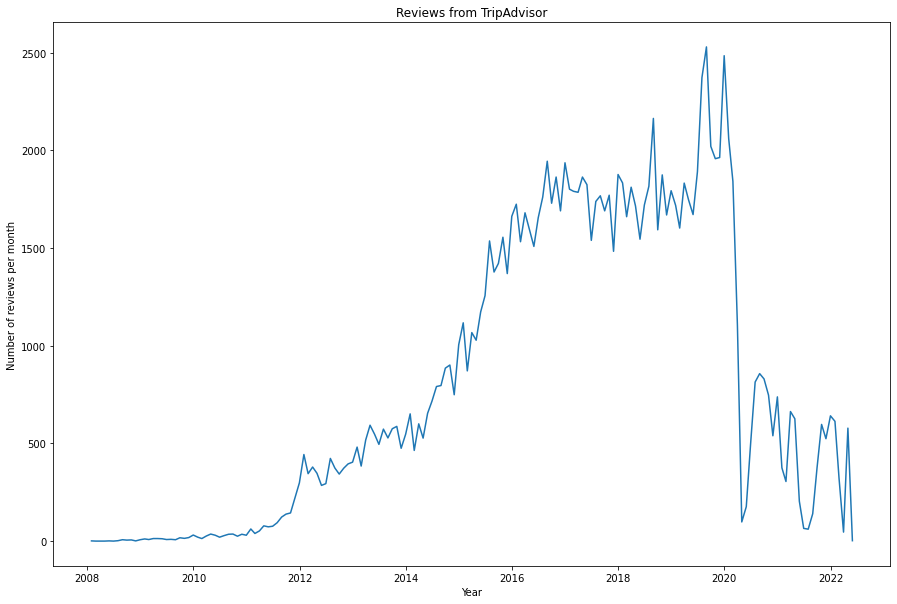

In [27]:
plt.figure(figsize=(15, 10))
plt.plot(df_TA.set_index("Date")["Review"].resample("M").count())
plt.xlabel('Year')
plt.ylabel('Number of reviews per month')
plt.title('Reviews from TripAdvisor')
plt.show()

### Overall no. of reviews per month breakdown by locations

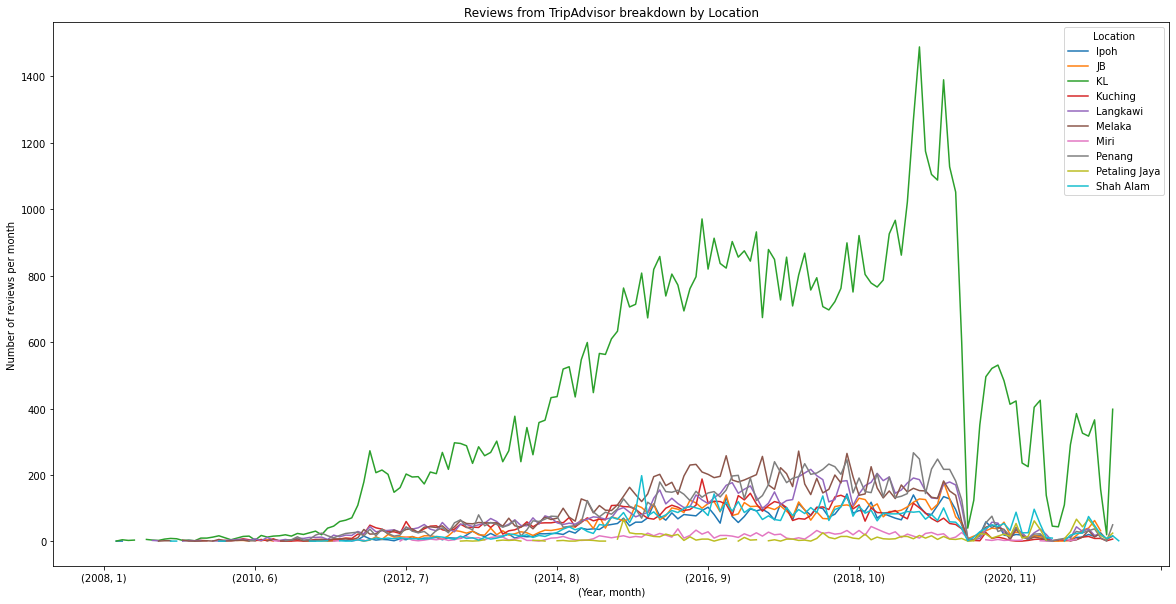

In [28]:
location_pivot = df_TA.pivot_table(index=[df_TA["Date"].dt.year, df_TA["Date"].dt.month],
                              columns="Location",
                              aggfunc="count")["Author"]
location_pivot.plot(figsize=(20, 10),
                    xlabel="(Year, month)",
                    ylabel="Number of reviews per month",
                   title="Reviews from TripAdvisor breakdown by Location");

It could be observe that the number of reviews dropped significanlty on the beginning of year 2020, which could corresponding to the start of COVID-19 pandemic in Malaysia.

The up and downs after the COVID-19 may corresponds to the MCO executed by the Malaysia government.

# Linguistic Features Analytics

In [29]:
# df of each category
df_positive = df[df["Rating"] > 3]
df_neutral = df[df["Rating"] == 3]
df_negative = df[df["Rating"] < 3]

In [30]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

stopwordz = set(stopwords.words("English"))
stopwordz.remove('not') # remove negative

## Unigram & WordCloud

In [31]:
# Unigram
# overall
texts = " ".join(review.lower() for review in df["Review"])
# remove punctuation
tokenizer = nltk.RegexpTokenizer(r"\w+")
tokens = tokenizer.tokenize(texts)
# remove stopwords
tokens = [token for token in tokens if token not in stopwordz]

overall_unigram = nltk.FreqDist(tokens).most_common(20)

In [32]:
overall_unigram
overallUnigram_df = pd.DataFrame(overall_unigram, columns=['Unigram', 'Count'])
overallUnigram_df

Unigram   Count
0         food  208145
1         good  145511
2          not   87382
3      service   83760
4        place   82728
5        great   71729
6         nice   67433
7   restaurant   64852
8        staff   46725
9    delicious   41794
10    friendly   38565
11         one   37525
12        best   37105
13      really   36711
14       price   35100
15     chicken   34627
16        time   33902
17       taste   32343
18        like   31600
19         try   31507

### Overall WordCloud

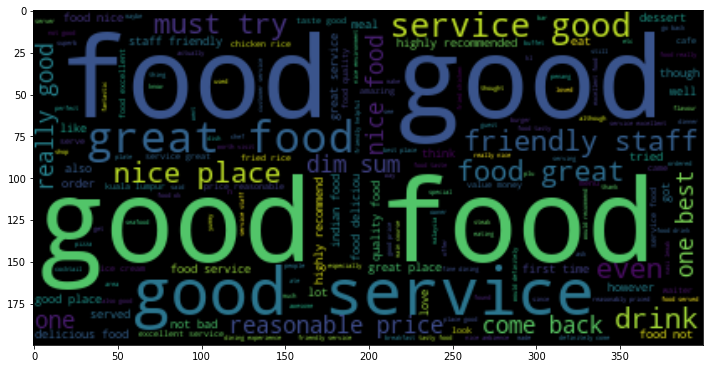

In [33]:
# overall
wordcloudz = WordCloud(stopwords=set(stopwordz)).generate(" ".join(tokens))

plt.figure(figsize = (12,8))
plt.imshow(wordcloudz, interpolation='bilinear');

## Unigram

### Positive Review

In [34]:
texts_positive = " ".join(review.lower() for review in df_positive["Review"])
# remove punctuation
tokenizer_positive = nltk.RegexpTokenizer(r"\w+")
tokens_positive = tokenizer.tokenize(texts_positive)
# remove stopwords
tokens_positive = [token for token in tokens_positive if token not in stopwordz]

positive_unigram = nltk.FreqDist(tokens_positive).most_common(20)

In [35]:
# top positive unigram
positiveUnigram_df = pd.DataFrame(positive_unigram, columns=['Unigram', 'Count'])
positiveUnigram_df

Unigram   Count
0         food  162607
1         good  121507
2        place   68247
3        great   66088
4      service   65491
5         nice   57890
6   restaurant   49845
7          not   45764
8    delicious   39303
9        staff   37799
10    friendly   35393
11        best   34125
12      really   29673
13         one   28039
14         try   27042
15       price   25554
16        also   25530
17     chicken   25426
18        time   25147
19        well   24551

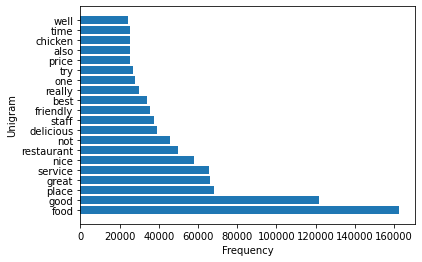

In [36]:
plt.barh(positiveUnigram_df['Unigram'], width=positiveUnigram_df["Count"]);
plt.xlabel('Frequency');
plt.ylabel('Unigram');

### Positive review word cloud

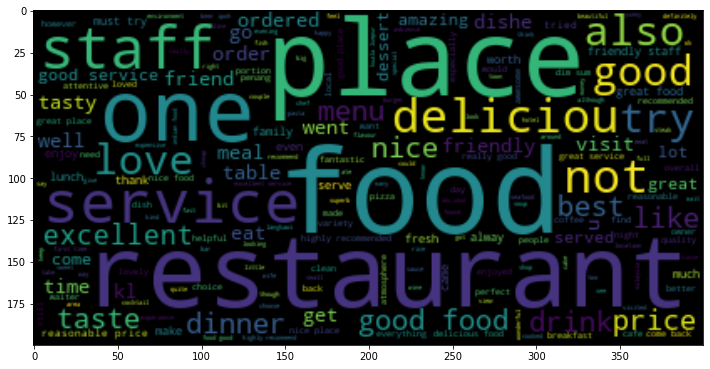

In [37]:
# positive
wordcloudz_positive = WordCloud(stopwords=set(stopwordz)).generate(texts_positive)
plt.figure(figsize = (12,8))
plt.imshow(wordcloudz_positive, interpolation='bilinear');

### Neutral Reviews

In [38]:
# neutral
texts_neutral = " ".join(review.lower() for review in df_neutral["Review"])
# remove punctuation
tokenizer_neutral = nltk.RegexpTokenizer(r"\w+")
tokens_neutral = tokenizer.tokenize(texts_neutral)
# remove stopwords
tokens_neutral = [token for token in tokens_neutral if token not in stopwordz]

neutral_unigram = nltk.FreqDist(tokens_neutral).most_common(20)

In [39]:
# Top neutral unigram
neutralUnigram_df = pd.DataFrame(neutral_unigram, columns=['Unigram', 'Count'])
neutralUnigram_df

Unigram  Count
0         food  24472
1          not  19250
2         good  16550
3        place   8685
4      service   8671
5   restaurant   7633
6         nice   6913
7        taste   5998
8        price   5427
9      chicken   5137
10        like   4605
11          ok   4552
12         one   4330
13     average   4328
14       quite   4131
15        time   4108
16       staff   3941
17       great   3934
18     ordered   3838
19         bit   3704

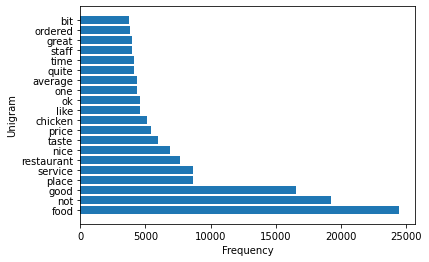

In [40]:
plt.barh(neutralUnigram_df['Unigram'], width=neutralUnigram_df["Count"]);
plt.xlabel('Frequency');
plt.ylabel('Unigram');

### Neutral review word cloud

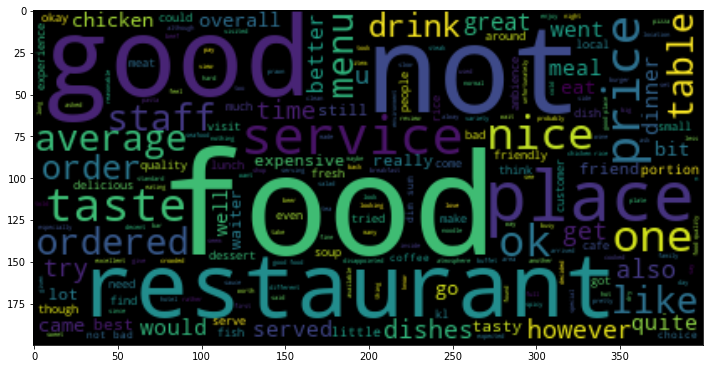

In [41]:
wordcloudz_neutral = WordCloud(stopwords=set(stopwordz)).generate(texts_neutral)
plt.figure(figsize = (12,8))
plt.imshow(wordcloudz_neutral, interpolation='bilinear');

### Negative Reviews

In [42]:
# negative
texts_negative = " ".join(review.lower() for review in df_negative["Review"])
# remove punctuation
tokenizer_negative = nltk.RegexpTokenizer(r"\w+")
tokens_negative = tokenizer.tokenize(texts_negative)

# remove stopwords
tokens_negative = [token for token in tokens_negative if token not in stopwordz]

negative_unigram = nltk.FreqDist(tokens_negative).most_common(20)

In [43]:
negativeUnigram_df = pd.DataFrame(negative_unigram, columns=['Unigram', 'Count'])
negativeUnigram_df

Unigram  Count
0          not  22368
1         food  21066
2      service   9598
3         good   7454
4   restaurant   7374
5        place   5796
6           us   5569
7          one   5156
8         like   5029
9        taste   5029
10       staff   4985
11     ordered   4947
12         bad   4769
13        time   4647
14       order   4345
15        even   4144
16       price   4119
17     chicken   4064
18       table   3658
19        came   3548

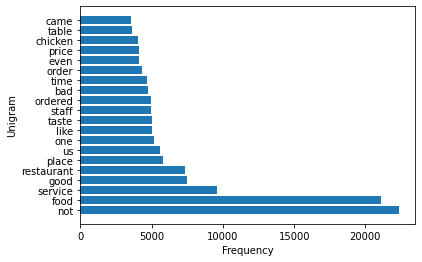

In [44]:
plt.barh(negativeUnigram_df['Unigram'], width=negativeUnigram_df["Count"]);
plt.xlabel('Frequency');
plt.ylabel('Unigram');

### Negative review word cloud

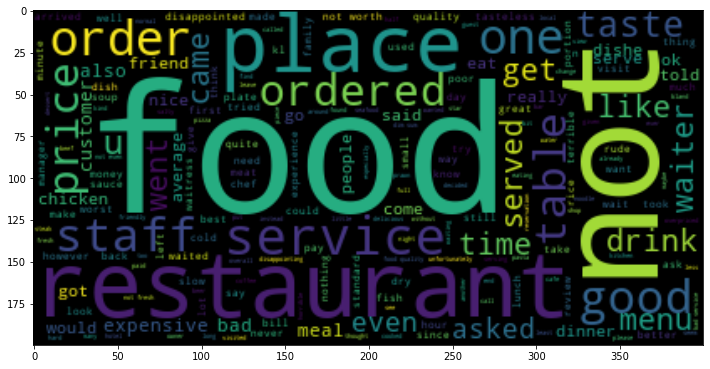

In [45]:
wordcloudz_negative = WordCloud(stopwords=set(stopwordz)).generate(texts_negative)
plt.figure(figsize = (12,8))
plt.imshow(wordcloudz_negative, interpolation='bilinear');

### Combination of unigrams for 3 sentiments

In [46]:
# breakdown by each sentiment
unigram_combined_df_each = pd.concat([
    positiveUnigram_df.rename(columns={'Unigram': 'Positive'})['Positive'],
    neutralUnigram_df.rename(columns={'Unigram': 'Neutral'})['Neutral'],
    negativeUnigram_df.rename(columns={'Unigram': 'Negative'})['Negative']
    ], axis=1).head(10)
unigram_combined_df_each

Positive     Neutral    Negative
0        food        food         not
1        good         not        food
2       place        good     service
3       great       place        good
4     service     service  restaurant
5        nice  restaurant       place
6  restaurant        nice          us
7         not       taste         one
8   delicious       price        like
9       staff     chicken       taste

In [47]:
# overall
unigram_combined_df = pd.concat([
    positiveUnigram_df,
    neutralUnigram_df,
    negativeUnigram_df
], axis=0).head(10)
unigram_combined_df

Unigram   Count
0        food  162607
1        good  121507
2       place   68247
3       great   66088
4     service   65491
5        nice   57890
6  restaurant   49845
7         not   45764
8   delicious   39303
9       staff   37799

It could be observed that, the top common attributes are **food, place, service**

## Bigram

In [48]:
# Take note on memory on vectorizer, limit max features

In [49]:
from sklearn.feature_extraction.text import CountVectorizer

# bigram vectorizer
vect = CountVectorizer(stop_words=stopwordz, ngram_range=(2, 2), max_features=1000)

### Bigram for Positive Review

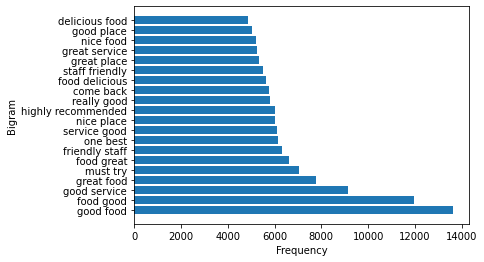

In [50]:
# Positive reviews

bigrams_positive = vect.fit_transform(df_positive['Review'])
bigram_positive_df = pd.DataFrame(
    bigrams_positive.toarray(), columns=vect.get_feature_names_out())

bigram_frequency = pd.DataFrame(bigram_positive_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['bigram', 'frequency']
bigram_frequency = bigram_frequency.sort_values(
    by='frequency', ascending=False).head(20)

plt.barh(bigram_frequency["bigram"], width=bigram_frequency["frequency"]);
plt.xlabel('Frequency');
plt.ylabel('Bigram');

There are many positive bigrams can be observed, usch as "good food", "food good", "good service", "must try", "nice place" etc.

### Bigram for Neutral Reviews

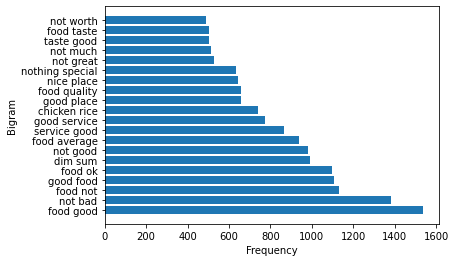

In [51]:
# Neutral reviews
bigrams_neutral = vect.fit_transform(df_neutral['Review'])
bigram_neutral_df = pd.DataFrame(
    bigrams_neutral.toarray(), columns=vect.get_feature_names_out())
bigram_frequency = pd.DataFrame(bigram_neutral_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['bigram', 'frequency']
bigram_frequency = bigram_frequency.sort_values(
    by='frequency', ascending=False).head(20)

plt.barh(bigram_frequency["bigram"], width=bigram_frequency["frequency"]);
plt.xlabel('Frequency');
plt.ylabel('Bigram');

The top bigram (food good) for both positive and neutral are the same.

This shows that the neutral sentiment class is rather ambiguous, in which some reviews with "food good" are positive reviews, but some are neutral reviews, at the same time there are more negative bigrams, such as "not great", "not good", but also within the neutral sentiment.

However, there are some more neutral bigrams notices, such as "not bad", "food ok" etc. 

### Bigram for Negative Reviews

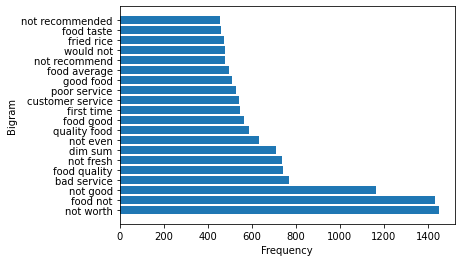

In [52]:
# %%
# negative reviews
bigrams_negative = vect.fit_transform(df_negative['Review'])
bigram_negative_df = pd.DataFrame(
    bigrams_negative.toarray(), columns=vect.get_feature_names_out())
bigram_frequency = pd.DataFrame(bigram_negative_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['bigram', 'frequency']
bigram_frequency = bigram_frequency.sort_values(
    by='frequency', ascending=False).head(20)

plt.barh(bigram_frequency["bigram"], width=bigram_frequency["frequency"]);
plt.xlabel('Frequency');
plt.ylabel('Bigram');

Many negative bigrams can be observed, such as  "not worth", "bad service", "not good", "not recommended" and many other negate lexicons, such as "food not", "not even", and "would not"

## Trigram

In [53]:
# Trigram vectorizer
vect = CountVectorizer(stop_words=stopwordz, ngram_range=(3, 3), max_features=1000)

### Positive Trigrams

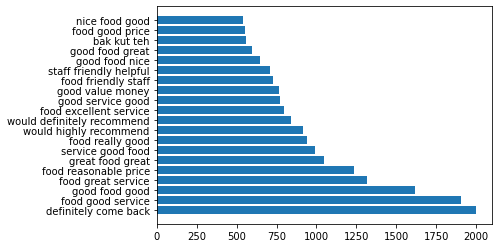

In [54]:
# Positive reviews

trigram_positive = vect.fit_transform(df_positive['Review'])
trigram_positive_df = pd.DataFrame(
    trigram_positive.toarray(), columns=vect.get_feature_names_out())

trigram_frequency = pd.DataFrame(trigram_positive_df.sum(axis=0)).reset_index()
trigram_frequency.columns = ['trigram', 'frequency']
trigram_frequency = trigram_frequency.sort_values(
    by='frequency', ascending=False).head(20)

plt.barh(trigram_frequency["trigram"], width=trigram_frequency["frequency"]);

If based on trigram, the service is top most common lexicons, followed by food, and then price.

### Neutral Trigrams

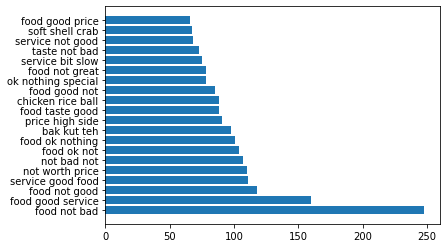

In [55]:
# neutral reviews

trigram_neutral = vect.fit_transform(df_neutral['Review'])
trigram_neutral_df = pd.DataFrame(
    trigram_neutral.toarray(), columns=vect.get_feature_names_out())

trigram_frequency = pd.DataFrame(trigram_neutral_df.sum(axis=0)).reset_index()
trigram_frequency.columns = ['trigram', 'frequency']
trigram_frequency = trigram_frequency.sort_values(
    by='frequency', ascending=False).head(20)

plt.barh(trigram_frequency["trigram"], width=trigram_frequency["frequency"]);

### Negative Trigrams

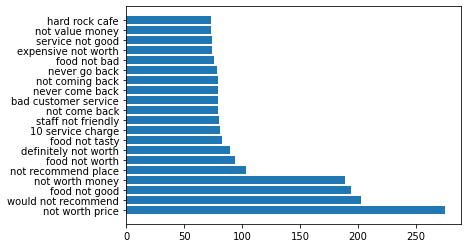

In [56]:
# negative reviews

trigram_negative = vect.fit_transform(df_negative['Review'])
trigram_negative_df = pd.DataFrame(
    trigram_negative.toarray(), columns=vect.get_feature_names_out())

trigram_frequency = pd.DataFrame(trigram_negative_df.sum(axis=0)).reset_index()
trigram_frequency.columns = ['trigram', 'frequency']
trigram_frequency = trigram_frequency.sort_values(
    by='frequency', ascending=False).head(20)

plt.barh(trigram_frequency["trigram"], width=trigram_frequency["frequency"]);

I can be observed that most negative review will mention not worth the price, not recommended, followed by food.

## POS Tagging

In [57]:
# dicts of pos tags:
posTagDict = {
    'CC': 'Conjunction',
    'CD': 'cardinal digit',
    'DT': 'determiner',
    'EX': 'existential',
    'FW': 'foreign word',
    'IN': 'preposition/subordinating conjunction',
    'JJ': 'adjective',
    'JJR': 'adjective, comparative',
    'JJS': 'adjective, superlative',
    'LS': 'list marker',
    'MD': 'modal',
    'NN': 'noun, singular',
    'NNS': 'noun plural',
    'NNP': 'proper noun',
    'NNPS': 'proper noun',
    'PDT': 'predeterminer',
    'POS': 'possessive ending',
    'PRP': 'personal pronoun',
    'PRP$': 'possessive pronoun',
    'RB': 'adverb',
    'RBR': 'adverb',
    'RBS': 'adverb, superlative',
    'RP': 'particle',
    'TO': 'to',
    'UH': 'interjection',
    'VB': 'verb, base form',
    'VBD': 'verb, past tense',
    'VBG': 'verb, gerund/present',
    'VBN': 'verb, past participle taken',
    'VBP': 'verb, present',
    'VBZ': 'verb, 3rd person',
    'WDT': 'wh-determiner',
    'WP': 'wh-pronoun',
    'WP$': 'possessive wh-pronoun',
    'WRB': 'wh-abverb where, when',
}

In [58]:
# pos_tagging

# Overall pos tags
df_pos = df.copy()
df_pos["tag"] = df_pos["Review"].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x)))

In [59]:
# POS tagging example
df_pos[['Review', 'tag']]

Review  \
0       David, Thanga, Mikail and Chef Steven gave bri...   
1       We visited for family celebration and as usual...   
2       Perfect dinner after a long journey.After trav...   
3       Had a great Tomahawk for me and hubby thanks t...   
4       Excellent ambient. Excellent service by David,...   
...                                                   ...   
339690  Delicious food. I passed by this place while s...   
339691  To put it mildly, Horrible food, Horrible cust...   
339692  Good vegetarian selection and the food was gre...   
339693  Simple atmosphere with fresh air (on a rainy n...   
339694                             Very good Cheese Naan!   

                                                      tag  
0       [(David, NNP), (,, ,), (Thanga, NNP), (,, ,), ...  
1       [(We, PRP), (visited, VBD), (for, IN), (family...  
2       [(Perfect, NNP), (dinner, NN), (after, IN), (a...  
3       [(Had, VBD), (a, DT), (great, JJ), (Tomahawk, ...  
4       [(Excellent, JJ), (ambient, NN), (., .), (Exce...  
...                                                   ...  
339690  [(Delicious, JJ), (food, NN), (., .), (I, PRP)...  
339691  [(To, TO), (put, VB), (it, PRP), (mildly, RB),...  
339692  [(Good, JJ), (vegetarian, JJ), (selection, NN)...  
339693  [(Simple, NN), (atmosphere, RB), (with, IN), (...  
339694  [(Very, RB), (good, JJ), (Cheese, NNP), (Naan,...  

[339695 rows x 2 columns]

In [60]:
# combine all into 1 list
pos_tags = [item for row in df_pos["tag"] for item in row] 

In [61]:
# Top POS for each category
def top_pos(tag):
    words = [word[0] for word in pos_tags if word[1].startswith(tag)]
    
    # remove punctuations
    words_joined = " ".join(word.lower() for word in words)
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    new_words = tokenizer.tokenize(words_joined)
    
    # remove stop words
    new_words = [word for word in new_words if word not in stopwordz]
    
    pos_freq = nltk.FreqDist(new_words)
    
    return pos_freq.most_common(20)

#### Top Unigram POS Tags

In [62]:
overall_unigram_pos = overallUnigram_df['Unigram'].apply(lambda x: nltk.pos_tag(nltk.word_tokenize(x))[0])
overall_df = pd.DataFrame.from_records(overall_unigram_pos, columns=['Lexicon', 'POS Tag'])
overall_df['POS Tag'] = overall_df['POS Tag'].apply(lambda x: posTagDict.get(x))
overall_df.head(10)

Lexicon         POS Tag
0        food  noun, singular
1        good       adjective
2         not          adverb
3     service  noun, singular
4       place  noun, singular
5       great       adjective
6        nice       adjective
7  restaurant  noun, singular
8       staff  noun, singular
9   delicious       adjective

### Nouns

In [63]:
# nouns
nouns = top_pos("NN")

nouns_df = pd.DataFrame.from_records(nouns, columns=['Lexicon', 'Frequency'])
nouns_df.head(10) # top 10

Lexicon  Frequency
0        food     207237
1     service      82878
2       place      81919
3  restaurant      63547
4       staff      46335
5       price      34803
6        time      33630
7     chicken      29190
8       taste      27895
9      dishes      27026

### Adjective

In [64]:
adjs = top_pos("JJ")
adjs_df = pd.DataFrame.from_records(adjs, columns=['Lexicon', 'Frequency'])
adjs_df.head(10) # top 10

Lexicon  Frequency
0        good     141340
1       great      54911
2        nice      50057
3   delicious      36035
4        best      32191
5    friendly      31002
6   excellent      22123
7       fresh      16482
8       tasty      16339
9  reasonable      15614

### Verbs

In [65]:
verbs = top_pos("V")
verbs_df = pd.DataFrame.from_records(verbs, columns=['Lexicon', 'Frequency'])
verbs_df.head(10) # top 10

Lexicon  Frequency
0          try      25966
1           go      21647
2      ordered      21448
3         come      20373
4          get      18513
5         love      17978
6       served      17060
7    recommend      15934
8  recommended      14079
9          eat      13496

### Adverbs

In [66]:
adverbs = top_pos("RB")
adverbs_df = pd.DataFrame.from_records(adverbs, columns=['Lexicon', 'Frequency'])
adverbs_df.head(10) # top 10

Lexicon  Frequency
0         not      87976
1      really      36064
2           n      35899
3        also      30446
4        well      25090
5        back      22039
6  definitely      18895
7        even      17041
8       quite      16156
9      always      12185

### Overall

In [67]:
# Put into df
pos_list = [
    (nouns, "Noun"),
    (verbs, "Verb"),
    (adjs, "Adjective"),
    (adverbs, "Adverb"),
]

data = []
for pos, pos_name in pos_list:
    pos_df = pd.DataFrame({pos_name: [word[0] for word in pos]})
    data.append(pos_df)
pos_df = pd.concat(data, axis=1)

In [68]:
pos_df.head(10)

Noun         Verb   Adjective      Adverb
0        food          try        good         not
1     service           go       great      really
2       place      ordered        nice           n
3  restaurant         come   delicious        also
4       staff          get        best        well
5       price         love    friendly        back
6        time       served   excellent  definitely
7     chicken    recommend       fresh        even
8       taste  recommended       tasty       quite
9      dishes          eat  reasonable      always

The top common lexicons for nouns, verbs, adjectives, and adverb, are shown on top

## Lexicon Polarity

In [69]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# download necessary package
# nltk.download('vader_lexicon');

In [70]:
# Run lexicon polarity
polarityAnalyzer = SentimentIntensityAnalyzer()
df_polarity = df.copy()
df_polarity['Polarity_raw'] = df_polarity['Review'].apply(lambda x: polarityAnalyzer.polarity_scores(x))

In [71]:
df_polarity['Compound'] = df_polarity['Polarity_raw'].apply(lambda x: x['compound'])
df_polarity['Positive'] = df_polarity['Polarity_raw'].apply(lambda x: x['pos'])
df_polarity['Neutral'] = df_polarity['Polarity_raw'].apply(lambda x: x['neu'])
df_polarity['Negative'] = df_polarity['Polarity_raw'].apply(lambda x: x['neg'])

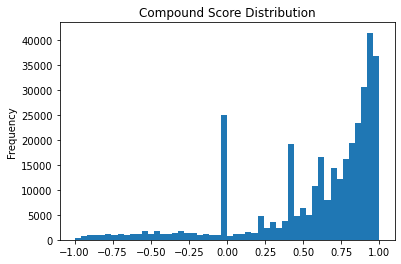

In [72]:
# compound score distribution
df_polarity['Compound'].plot(kind='hist', ylabel="Frequency", title="Compound Score Distribution", bins=50);

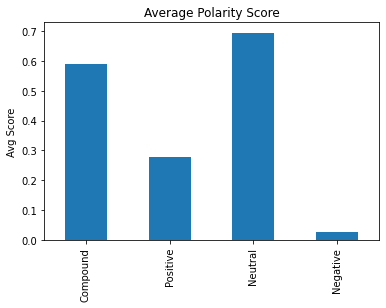

In [73]:
df_polarity[['Compound', 'Positive', 'Neutral', 'Negative']].mean().plot(kind='bar', ylabel="Avg Score",
                                    title="Average Polarity Score");